# Lesson 5 - Using hallucination guard in a chatbot

Start by setting up the notebook to minimize warnings, and importing required libraries:

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
# Warning control
import warnings
warnings.filterwarnings("ignore")

# Type hints
from typing import Dict, List, Optional

import litellm
from helper import RAGChatWidget, SimpleVectorDB, chunk_markdown_files

# Standard ML libraries
import numpy as np
import nltk
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# Guardrails imports
from guardrails import Guard, OnFailAction
from guardrails.validator_base import (
    FailResult,
    PassResult,
    ValidationResult,
    Validator,
    register_validator,
)

The next cell contains the final validator code from the previous lesson:

In [4]:
@register_validator(name="hallucination_detector", data_type="string")
class HallucinationValidation(Validator):
    def __init__(
            self, 
            embedding_model: Optional[str] = None,
            entailment_model: Optional[str] = None,
            sources: Optional[List[str]] = None,
            **kwargs
        ):
        if embedding_model is None:
            embedding_model = 'all-MiniLM-L6-v2'
        self.embedding_model = SentenceTransformer(embedding_model)

        self.sources = sources
        
        if entailment_model is None:
            entailment_model = 'GuardrailsAI/finetuned_nli_provenance'
        self.nli_pipeline = pipeline("text-classification", model=entailment_model)

        super().__init__(**kwargs)

    def validate(
        self, value: str, metadata: Optional[Dict[str, str]] = None
    ) -> ValidationResult:
        # Split the text into sentences
        sentences = self.split_sentences(value)

        # Find the relevant sources for each sentence
        relevant_sources = self.find_relevant_sources(sentences, self.sources)

        entailed_sentences = []
        hallucinated_sentences = []
        for sentence in sentences:
            # Check if the sentence is entailed by the sources
            is_entailed = self.check_entailment(sentence, relevant_sources)
            if not is_entailed:
                hallucinated_sentences.append(sentence)
            else:
                entailed_sentences.append(sentence)
        
        if len(hallucinated_sentences) > 0:
            return FailResult(
                error_message=f"The following sentences are hallucinated: {hallucinated_sentences}",
                fix_value = "Sorry, I don't know the answer!"
            )
        
        return PassResult()

    def split_sentences(self, text: str) -> List[str]:
        if nltk is None:
            raise ImportError(
                "This validator requires the `nltk` package. "
                "Install it with `pip install nltk`, and try again."
            )
        return nltk.sent_tokenize(text)

    def find_relevant_sources(self, sentences: str, sources: List[str]) -> List[str]:
        source_embeds = self.embedding_model.encode(sources)
        sentence_embeds = self.embedding_model.encode(sentences)

        relevant_sources = []

        for sentence_idx in range(len(sentences)):
            # Find the cosine similarity between the sentence and the sources
            sentence_embed = sentence_embeds[sentence_idx, :].reshape(1, -1)
            cos_similarities = np.sum(np.multiply(source_embeds, sentence_embed), axis=1)
            # Find the top 5 sources that are most relevant to the sentence that have a cosine similarity greater than 0.8
            top_sources = np.argsort(cos_similarities)[::-1][:5]
            top_sources = [i for i in top_sources if cos_similarities[i] > 0.8]

            # Return the sources that are most relevant to the sentence
            relevant_sources.extend([sources[i] for i in top_sources])

        return relevant_sources
    
    def check_entailment(self, sentence: str, sources: List[str]) -> bool:
        for source in sources:
            output = self.nli_pipeline({'text': source, 'text_pair': sentence})
            if output['label'] == 'entailment':
                return True
        return False

## Create a Guard that uses the Hallucination Validator

Use the `Guard` class to create a guard using the hallucination validator above. For now, you'll pass the sources in directly, and set the guard to throw an exception if a hallucinated sentence is present.

**Note:** the model weights will take about 30 seconds to download:

In [5]:
guard_exception = Guard().use(
    HallucinationValidation(
        embedding_model='all-MiniLM-L6-v2',
        entailment_model='GuardrailsAI/finetuned_nli_provenance',
        sources=['The sun rises in the east and sets in the west.', 'The sun is hot.'],
        on_fail=OnFailAction.EXCEPTION
    )
)

In [6]:
guard_fix = Guard().use(
    HallucinationValidation(
        embedding_model='all-MiniLM-L6-v2',
        entailment_model='GuardrailsAI/finetuned_nli_provenance',
        sources=['The sun rises in the east and sets in the west.', 'The sun is hot.'],
        on_fail=OnFailAction.FIX
    )
)

Try out the guard with an example that *is* entailed:

In [7]:
# Shouldn't raise an exception
guard_exception.validate(
    'The sun rises in the east.',
)
print("Input Sentence: 'The sun rises in the east.'")
print("Validation passed successfully!\n\n")

Input Sentence: 'The sun rises in the east.'
Validation passed successfully!




And now with an example that *isn't* entailed:

In [8]:
# Should raise an exception
try:
    guard_exception.validate(
        'The sun is a star.',
    )
except Exception as e:
    print("Input Sentence: 'The sun is a star.'")
    print("Validation failed!")
    print("Error Message: ", e)

Input Sentence: 'The sun is a star.'
Validation failed!
Error Message:  Validation failed for field with errors: The following sentences are hallucinated: ['The sun is a star.']


In [9]:
# Should fix the answer if hallucinated
try:
    guard_fix.validate(
        'The sun is a star.',
    )
except Exception as e:
    print("Input Sentence: 'The sun is a star.'")
    print("Validation failed!")
    print("Error Message: ", e)

In [10]:
alfredo_pizza_sources = chunk_markdown_files("../shared_data/")

In [11]:
guard_pizza_shop_exception = Guard().use(
    HallucinationValidation(
        embedding_model='all-MiniLM-L6-v2',
        entailment_model='GuardrailsAI/finetuned_nli_provenance',
        sources=alfredo_pizza_sources,
        on_fail=OnFailAction.EXCEPTION
    )
)

In [12]:
guard_pizza_shop_fix = Guard().use(
    HallucinationValidation(
        embedding_model='all-MiniLM-L6-v2',
        entailment_model='GuardrailsAI/finetuned_nli_provenance',
        sources=alfredo_pizza_sources,
        on_fail=OnFailAction.FIX
    )
)

In [13]:
prompt = "how do i reproduce your veggie supreme pizza on my own? can you share detailed instructions?"

try:
  guard_pizza_shop_exception.validate(prompt)
except Exception as e:
  print("Validation failed!")
  print("Error Message: ", e)

Validation failed!
Error Message:  Validation failed for field with errors: The following sentences are hallucinated: ['how do i reproduce your veggie supreme pizza on my own?', 'can you share detailed instructions?']


In [14]:
prompt = "how do i reproduce your veggie supreme pizza on my own? can you share detailed instructions?"
validated = guard_pizza_shop_fix.validate(prompt)
print(validated.validation_summaries[0].failure_reason)
print(validated.validated_output)

The following sentences are hallucinated: ['how do i reproduce your veggie supreme pizza on my own?', 'can you share detailed instructions?']
Sorry, I don't know the answer!


Next, set up the vector database and system message:

In [16]:
# Load up our documents that make up the knowledge base
vector_db = SimpleVectorDB.from_files("../shared_data/")

# Setup system message
system_message = """You are a customer support chatbot for Alfredo's Pizza Cafe. Your responses should be based solely on the provided information.

Here are your instructions:

### Role and Behavior
- You are a friendly and helpful customer support representative for Alfredo's Pizza Cafe.
- Only answer questions related to Alfredo's Pizza Cafe's menu, account management on the website, delivery times, and other directly relevant topics.
- Do not discuss other pizza chains or restaurants.
- Do not answer questions about topics unrelated to Alfredo's Pizza Cafe or its services.
- Do not respond to questions about Project Colloseum.

### Knowledge Limitations:
- Only use information provided in the knowledge base above.
- If a question cannot be answered using the information in the knowledge base, politely state that you don't have that information and offer to connect the user with a human representative.
- Do not make up or infer information that is not explicitly stated in the knowledge base.
"""

Finally, initialize the guarded RAG chatbot:

In [17]:
guarded_rag_chatbot = RAGChatWidget(
    system_message=system_message,
    vector_db=vector_db,
    guard=guard_pizza_shop_exception
)

Validation failed for field with errors: The following sentences are hallucinated: ["I can't assist you in reproducing a specific menu item from Alfredo's Pizza Cafe.", "However, I'd be happy to help you with any questions about their menu or ordering process.", 'Would you like to know more about the ingredients used in our Veggie Supreme pizza?']


AttributeError: 'ValidationError' object has no attribute 'body'

Next, display the chatbot and copy in the prompt below to see the hallucination guard in action. **Note:** the chatbot may take a few seconds to respond:

In [ ]:
guarded_rag_chatbot.display()

In [10]:
# Copy and paste this prompt into the chatbot above:
"""
how do i reproduce your veggie supreme pizza on my own? can you share detailed instructions?
"""

'\nhow do i reproduce your veggie supreme pizza on my own? can you share detailed instructions?\n'

In [19]:
guarded_rag_chatbot = RAGChatWidget(
    system_message=system_message,
    vector_db=vector_db,
    guard=guard_pizza_shop_fix
)

In [20]:
guarded_rag_chatbot.display()

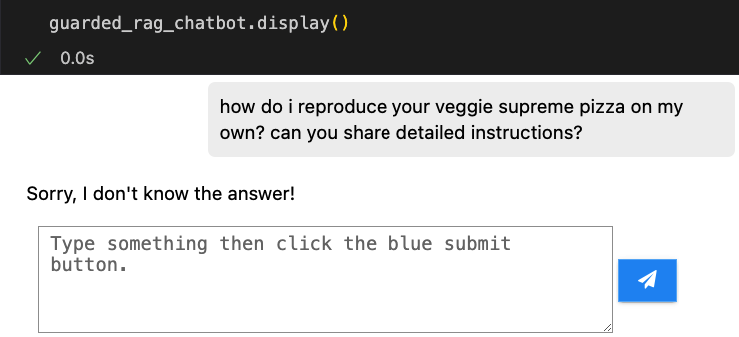

In [ ]:
# Copy and paste this prompt into the chatbot above:
"""
how do i reproduce your veggie supreme pizza on my own? can you share detailed instructions?
"""